In [1]:
# notebook to develop monolith simulator for Cantera version 2.6.0

Some design decisions to make:
    - make temperature profile optional/specify temperature csv?
    - how many CSTRs?
    - include timeout
    












In [1]:
import cantera as ct
import numpy as np
import scipy.signal
import os
import copy
import scipy.interpolate

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

print(ct.__version__)

2.6.0


In [3]:
# Pt111
# mech_yaml = '/home/moon/uncertainty_estimator/nam29_presentation/cpox_Pt/chem_annotated.yaml'
# mech_yaml = '/home/moon/uncertainty_estimator/beef/cpox_Pt/chem_annotated.yaml'
# mech_yaml = '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20251225/cantera/handbuilt3.yaml'
# mech_yaml = '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20251225/cantera/chem_annotated.yaml'
mech_yaml = '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20251229/cantera/chem_annotated.yaml'
chemkin_gas = '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20251229/chemkin/chem_annotated-gas.inp'
# mech_yaml = '/home/moon/uncertainty_estimator/cpox_pt/korup/chem_annotated.yaml'
# mech_yaml = '/home/moon/uncertainty_estimator/cpox_pt/cpox_rh_emily/chem_annotated-gas.yaml'

# mech_yaml = '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20251229/cantera/chem_annotated_noCH4X.yaml'
# chemkin_gas = '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20251229/noCH4X/chem_annotated-gas.inp'
# mech_yaml = '/home/moon/uncertainty_estimator/cpox_pt/cpox_rh_bpe/DFT_map_mech.yaml'
gas = ct.Solution(mech_yaml, 'gas')
surf = ct.Interface(mech_yaml, 'surface1', [gas])

print(f'This mechanism contains {gas.n_species} gas species and {surf.n_species} surface species')
print(f'This mechanism contains {gas.n_reactions} gas reactions and {surf.n_reactions} surface reactions')

This mechanism contains 26 gas species and 22 surface species
This mechanism contains 97 gas reactions and 177 surface reactions


/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: StickingRate::validate: 
 Sticking coefficient is greater than 1 for reaction 'CH4(2) + 2 X(1) <=> CH3X(27) + HX(21)'
 at T = 5000.0

 Sticking coefficient is greater than 1 for reaction 'CH4(2) + 2 X(1) <=> CH3X(27) + HX(21)'
 at T = 10000.0

  from ipykernel import kernelapp as app


In [48]:
isinstance(surf, ct.Interface)

True

# Load an interpolation of temperature

706.7745030989495


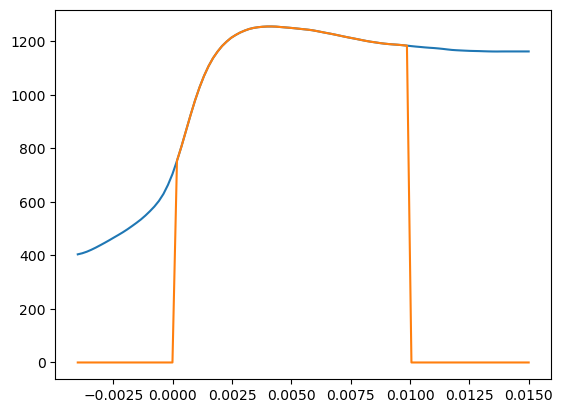

In [4]:
pt_data = '/home/moon/uncertainty_estimator/cpox_pt/horn_data/pt_profiles_smooth.csv'
df = pd.read_csv(pt_data)

distances = (df['Distance (mm)'] - 10.0) / 1000.0  # ignore the 10mm of no/catalyst space
exp_Ts = df['Temperature (K)']

f = scipy.interpolate.interp1d(distances, exp_Ts, fill_value='extrapolate')

plt.plot(distances, exp_Ts)
cat_values = np.zeros_like(distances)
for i in range(len(distances)):
    if distances[i] > 0.0 and distances[i] < 0.01:
        cat_values[i] = 1.0
catalyst_on = scipy.interpolate.interp1d(distances, cat_values, fill_value=0.0, bounds_error=False)

example_distances = np.linspace(np.min(distances), np.max(distances), 101)
plt.plot(example_distances, [f(x) * catalyst_on(x) for x in example_distances] )
print(f(0))  # should be close to 700K

In [5]:
f(-0.01)

array(276.04377321)

In [6]:
np.min(distances)

-0.004

In [7]:
def get_i_thing(ref_composition, phase):
    for i in range(phase.n_species):
        if phase.species()[i].composition == ref_composition:
            return i
    assert False
    return -1

In [8]:
# Get indices of key species
i_Ar = get_i_thing({'Ar': 1.0}, gas)
i_CH4 = get_i_thing({'C': 1.0, 'H': 4.0}, gas)
i_O2 = get_i_thing({'O': 2.0}, gas)
i_CO2 = get_i_thing({'C': 1.0, 'O': 2.0}, gas)
i_H2O = get_i_thing({'H': 2.0, 'O': 1.0}, gas)
i_H2 = get_i_thing({'H': 2.0}, gas)
i_CO = get_i_thing({'C': 1.0, 'O': 1.0}, gas)
i_C2H4 = get_i_thing({'C': 2.0, 'H': 4.0}, gas)
i_X = get_i_thing({'X': 1.0}, surf)
i_OX = get_i_thing({'X': 1.0, 'O': 1.0}, surf)
i_CX = get_i_thing({'X': 1.0, 'C': 1.0}, surf)
i_CO2X = get_i_thing({'X': 1.0, 'C': 1.0, 'O': 2.0}, surf)
i_COX = get_i_thing({'X': 1.0, 'C': 1.0, 'O': 1.0}, surf)
i_HX = get_i_thing({'X': 1.0, 'H': 1.0}, surf)
i_CH3X = get_i_thing({'X': 1.0, 'H': 3.0, 'C': 1.0}, surf)
i_H2OX = get_i_thing({'X': 1.0, 'H': 2.0, 'O': 1.0}, surf)
i_H2X = get_i_thing({'X': 1.0, 'H': 2.0}, surf)

In [9]:
def increase_enthalpy(phase, species_index, increase_enthalpy_J_per_kmol):
    data_copy = copy.deepcopy(phase.species()[species_index].input_data)
    for i in range(len(data_copy['thermo']['data'])):
        data_copy['thermo']['data'][i][5] += increase_enthalpy_J_per_kmol / ct.gas_constant
    new_sp = ct.Species().from_dict(data_copy)
    phase.modify_species(species_index, new_sp)

In [20]:
#######################################################################
# Input Parameters
#######################################################################

N_reactors = 1001
T_in = 700

use_temperature_profile = False

MIN_SIM_DIST = -0.005  # in meters
MAX_SIM_DIST = 0.020  # in meters
total_pfr_len = MAX_SIM_DIST - MIN_SIM_DIST


individual_cstr_len = total_pfr_len / N_reactors
dist_array = np.linspace(MIN_SIM_DIST, MAX_SIM_DIST, N_reactors)
temperature_profile = f(dist_array)

cat_on_index = np.argmin(np.abs(dist_array - 0))
cat_off_index = np.argmin(np.abs(dist_array - 0.01))


reactor_diameter = 0.0165
cross_section_area = (reactor_diameter / 2.0) ** 2.0 * np.pi
porosity = 0.81  # Monolith channel porosity, from Horn ref 17 sec 2.2.2
cat_area_per_vol = 16000  # made-up
flow_rate = 4.7  # slpm
flow_rate = flow_rate * 0.001 / 60  # m^3/s
tot_flow = 0.208  # from Horn 2007, constant inlet flow rate in mol/min, equivalent to 4.7 slpm
velocity = flow_rate / cross_section_area  # m/s

residence_time = individual_cstr_len / velocity # unit in s

# The PFR will be simulated by a chain of 'NReactors' stirred reactors
# but we'll assume there's catalyst throughout the whole reactor
individual_cstr_vol = cross_section_area * individual_cstr_len * porosity

# catalyst area in one reactor
individual_cstr_cat_area = cat_area_per_vol * individual_cstr_vol

# Simulation section

In [42]:
T = T_in

gas = ct.Solution(mech_yaml, 'gas')
surf = ct.Interface(mech_yaml, 'surface1', [gas])

ten_kcal = 10000 * 4184
# increase_enthalpy(surf, i_OX, ten_kcal)




x_CH4 = 0.296
x_O2 = 0.147
x_Ar = 1.0 - x_CH4 - x_O2

X = f'{gas.species_names[i_CH4]}: {x_CH4}, {gas.species_names[i_O2]}: {x_O2}, {gas.species_names[i_Ar]}: {x_Ar}'

gas.TPX = 273.15, ct.one_atm, X  # need to initialize mass flow rate at STP
mass_flow_rate = flow_rate * gas.density_mass
gas.TPX = T, ct.one_atm, X
surf.TP = T, ct.one_atm

initial_coverages = np.zeros_like(surf.coverages)
initial_coverages[i_X] = 1.0
surf.coverages = initial_coverages


# create a new reactor
if use_temperature_profile:
    r = ct.IdealGasReactor(gas, energy='off')
else:
    r = ct.IdealGasReactor(gas, energy='on')
r.volume = individual_cstr_vol
upstream = ct.Reservoir(gas, name='upstream')
downstream = ct.Reservoir(gas, name='downstream')
rsurf = ct.ReactorSurface(surf, r, A=individual_cstr_cat_area)
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)
v = ct.PressureController(r, downstream, master=m, K=1e-5)

wall_on = True
env_temp = 300.0
wall_area = individual_cstr_len * np.pi * reactor_diameter
U_hx = 100.0
if wall_on:
    air = ct.Solution("air.yaml")
    air.TP = env_temp, ct.one_atm
    env = ct.Reservoir(air)

    # add a wall to the reactor
    w = ct.Wall(r, env, A = wall_area, U=U_hx)



sim = ct.ReactorNet([r])
sim.max_err_test_fails = 12


gas_names = gas.species_names
surf_names = surf.species_names
gas_out = []
surf_out = []
gas_rates = []
surf_rates = []

T_array = []


# start in the non-catalyst region
surf.set_multiplier(0.0)



for n in range(N_reactors):
    
    # Set the state of the reservoir to match that of the previous reactor
    if use_temperature_profile:
        gas.TDY = temperature_profile[n], r.thermo.DP[0], r.thermo.Y
        surf.TD = temperature_profile[n], surf.TD[1]
        r.syncState()
        upstream.syncState()

    else:
        gas.TDY = r.thermo.TDY
        upstream.syncState()
    
    sim.reinitialize()
    if n == cat_on_index:
        # turn the surface reactions on as we enter the catalyst region
        surf.set_multiplier(1.0)
    elif n == cat_off_index:
        # turn the surface reactions off as we exit the catalyst region
        surf.set_multiplier(0.0)

    
    try:
        sim.advance(sim.time + 1e4 * residence_time)
    except ct.CanteraError as e:
        print("error at reactor ", n)
        raise e

    T_array.append(surf.T)
    # print "mass_flow_rate", mass_flow_rate,  v.mdot(sim.time), "kg/s"
    kmole_flow_rate = mass_flow_rate / gas.mean_molecular_weight  # kmol/s
    gas_out.append(1000 * 60 * kmole_flow_rate * gas.X.copy())  # molar flow rate in moles/minute
    surf_out.append(surf.X.copy())
    gas_rates.append(gas.net_rates_of_progress)
    surf_rates.append(surf.net_rates_of_progress)



/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: StickingRate::validate: 
 Sticking coefficient is greater than 1 for reaction 'CH4(2) + 2 X(1) <=> CH3X(27) + HX(21)'
 at T = 5000.0

 Sticking coefficient is greater than 1 for reaction 'CH4(2) + 2 X(1) <=> CH3X(27) + HX(21)'
 at T = 10000.0

  after removing the cwd from sys.path.


In [43]:
gas_out = np.array(gas_out)
surf_out = np.array(surf_out)
gas_names = np.array(gas_names)
surf_names = np.array(surf_names)
gas_rates = np.array(gas_rates)
surf_rates = np.array(surf_rates)
N = len(gas_out)

Text(0.5, 1.0, '2.6.0         1001 reactors')

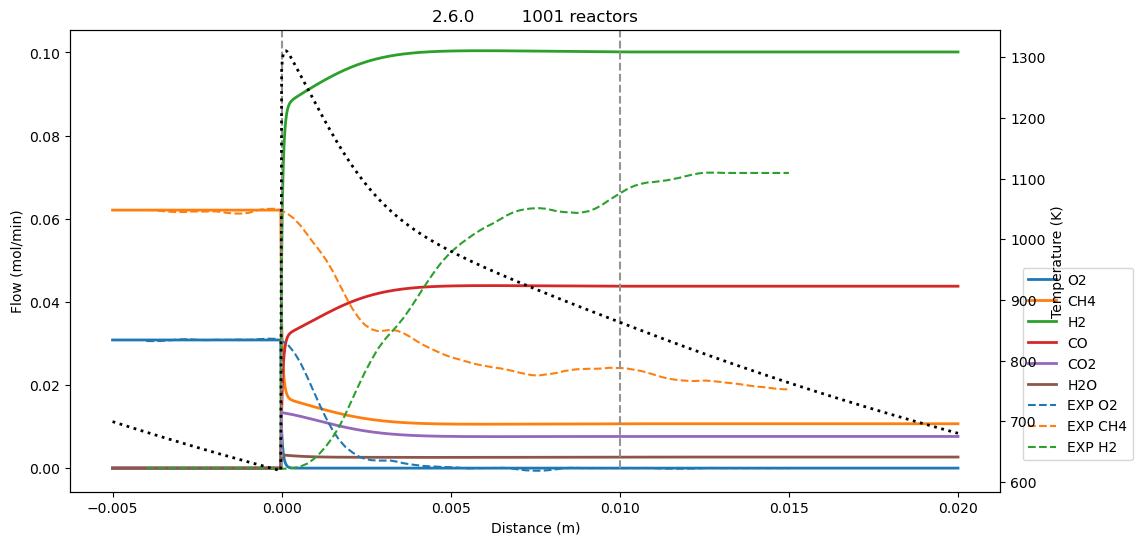

In [44]:
# Plot the result
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linewidth1 = 2.0
linewidth2 = 2.0

fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(12)

plt.plot(dist_array[:N], gas_out[:, i_O2], label='O2', color=colors[0], linewidth=linewidth2)
plt.plot(dist_array[:N], gas_out[:, i_CH4], label='CH4', color=colors[1], linewidth=linewidth2)
plt.plot(dist_array[:N], gas_out[:, i_H2], label='H2', color=colors[2], linewidth=linewidth2)
plt.plot(dist_array[:N], gas_out[:, i_CO], label='CO', color=colors[3], linewidth=linewidth2)
plt.plot(dist_array[:N], gas_out[:, i_CO2], label='CO2', color=colors[4], linewidth=linewidth2)
plt.plot(dist_array[:N], gas_out[:, i_H2O], label='H2O', color=colors[5], linewidth=linewidth2)


plt.plot((df['Distance (mm)'].values - 10.0) / 1000.0, df['O2 (mol/min)'].values, linestyle='dashed', label='EXP O2', color=colors[0])
plt.plot((df['Distance (mm)'].values - 10.0) / 1000.0, df['CH4 (mol/min)'].values, linestyle='dashed', label='EXP CH4', color=colors[1])
plt.plot((df['Distance (mm)'].values - 10.0) / 1000.0, df['H2 (mol/min)'].values, linestyle='dashed', label='EXP H2', color=colors[2])




ax1 = plt.gca()
ylim = ax1.get_ylim()
# Mark the catalyst extent
plt.plot([dist_array[cat_on_index], dist_array[cat_on_index]], [0, 1.0], linestyle='--', color='xkcd:grey')
plt.plot([dist_array[cat_off_index], dist_array[cat_off_index]], [0, 1.0], linestyle='--', color='xkcd:grey')
plt.ylim(ylim)

ax2 = ax1.twinx()
ax2.plot(dist_array[:N], T_array, label='Temperature', color='k', linestyle=':', linewidth=linewidth2)
ax2.set_ylabel('Temperature (K)')
ax2.yaxis.get_major_formatter().set_useOffset(False)
# ax2.set_ylim((832.6458681304853, 1380.7048767073081))

ax1.set_xlabel('Distance (m)')
ax1.set_ylabel('Flow (mol/min)')
ax1.legend(bbox_to_anchor=(1.15, 0.5))
# ax1.set_ylim((-0.005686988947011412, 0.1))
# ax1.set_xlim((-0.0004950495049504951, 0.010396039603960397))

plt.title(ct.__version__ + f'         {N_reactors} reactors')

# plt.axvline(x=dist_array[13], color='k')  # trick for finding place on x axis
# print(dist_array[13])